In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA   

Read the NSBCD file

In [2]:
file = open('NSBCD_train_1.csv', 'r')
line = file.readline()
NUM_FEATURES = len(line.split(",")) - 2
print(NUM_FEATURES)
survival_times = []
X = []
maximum_ob_time = 0
while line != "":
    segmentations = line.split(",")
    if segmentations[-1] == 1:
        continue
    else:
        survival_times.append(int(segmentations[-2]))
        entries = np.array(segmentations[:-2])
        for entry in entries:
            X.append(float(entry))
    line = file.readline()

NUM_TRAIN = int(len(X) / NUM_FEATURES)

file = open('NSBCD_test_1.csv', 'r')
line = file.readline()
while line != "":
    segmentations = line.split(",")
    if segmentations[-1] == 1:
        continue
    else:
        survival_times.append(int(segmentations[-2]))
        entries = np.array(segmentations[:-2])
        for entry in entries:
            X.append(float(entry))
    line = file.readline()

X = np.reshape(X, (-1, NUM_FEATURES))
# X = X[:,1:]
NUM_EMPLOYEES = X.shape[0]

# print(X.shape)
# pca=PCA(n_components=115)  
# X =pca.fit_transform(X)

NUM_VAL = NUM_EMPLOYEES - NUM_TRAIN

maximum_ob_time = max(survival_times)
Y = np.ones((NUM_EMPLOYEES, maximum_ob_time))
# print(X)
Mi = np.max(X, axis = 0)
mi = np.min(X, axis = 0)
mi[0] = 0
X = 2 * (X - mi) / (Mi - mi) -1
# print(X)
for i in range(NUM_EMPLOYEES):
    Y[i, survival_times[i] - 1:] = -1

# print(X[0])
print(X[0])

550
[ 1.00000000e+00 -9.60593451e-02 -4.66802236e-01  1.00000000e+00
 -5.21411066e-01  5.20446097e-02  2.62575263e-01 -1.91711813e-01
  8.10502283e-01 -2.74944568e-01  5.00000000e-01  3.01558466e-01
  4.90256791e-01 -7.24814942e-01  5.16709512e-01 -3.61038961e-01
 -8.92988930e-01 -9.05824323e-02 -3.50348028e-01  2.24971841e-01
  2.40131579e-01 -1.88786987e-01 -3.52154532e-01 -3.65269461e-01
  3.72718585e-01  1.89333333e-01  8.04051225e-01  2.43396287e-01
 -3.34261838e-02  3.22695418e-01 -9.03171953e-01 -1.41390434e-01
 -8.54951185e-01 -7.48560461e-02  1.64738209e-01 -4.96074770e-01
 -8.15219887e-02  1.90697674e-01  1.00000000e+00  6.15570400e-01
  3.74171458e-01  3.51285190e-01  7.85287405e-01  3.74811422e-01
 -5.95947557e-03  2.54889996e-01 -2.68535935e-02 -4.84937207e-01
  5.08368201e-01  1.33280715e-01 -2.38261930e-01 -1.00000000e+00
  3.36971441e-01 -9.03377557e-02 -1.40186561e-01  7.74358974e-01
 -8.52713178e-02  6.04026846e-02  3.04682971e-01 -7.91975143e-02
 -9.14407989e-01 -1.9

In [3]:
BANDWIDTH = 10
max_iteration = 10000
weight_decay = 0.01
d = 10

In [4]:
X_train = X[:NUM_TRAIN]
X_val = X[NUM_TRAIN:]
Y_train = Y[:NUM_TRAIN]
Y_val = Y[NUM_TRAIN:]

In [5]:
def Generating_Kernel(Feature_Matrix, Kernel_type, power=10, BW=10):
    if Kernel_type == "Gaussian_Kernel":
        square = np.sum(Feature_Matrix ** 2, axis=1)
        column_vec = square[:, np.newaxis]
        row_vec = square[np.newaxis, :]
        Gaussian_Kernel = np.exp(-1 * (-2 * Feature_Matrix.dot(Feature_Matrix.T) + column_vec + row_vec) / (2 * BW ** 2))
        return Gaussian_Kernel
    elif Kernel_type == "Linear_Kernel":
        return X.dot(X.T)
    elif Kernel_type == "Polynomial_Kernel":
        return (X.dot(X.T) + 1) ** power

In [6]:
square = np.sum(X ** 2, axis=1)
column_vec = square[:, np.newaxis]
row_vec = square[np.newaxis, :]

Gaussian_Kernel = np.exp(-1 * (-2 * X.dot(X.T) + column_vec + row_vec) / (2 * BANDWIDTH ** 2)) # the Gaussian Kernel
# Gaussian_Kernel = ((X.dot(X.T)) + 1) ** d

# norm_matrix = (square[:,np.newaxis].dot(square[np.newaxis,:])) ** 0.5
# Gaussian_Kernel = X.dot(X.T) # / norm_matrix



In [7]:
Kernel_Matrix = Generating_Kernel(X, "Gaussian_Kernel", BW = BANDWIDTH)
Kernel_Matrix_Train = Kernel_Matrix[:NUM_TRAIN,:NUM_TRAIN]
Kernel_Matrix_Val = Kernel_Matrix[NUM_TRAIN:,:NUM_TRAIN]

In [8]:
def kernel_pegasos(batch_size, Kernel_Matrix, alpha, Y_truth, iter_times, weight_decay):
    IDs = np.random.rand(batch_size,1) * NUM_TRAIN
    IDs = IDs.astype(int).reshape(-1)
    haty_IDs = (Kernel_Matrix[IDs].dot(alpha * Y_truth))  / (iter_times * weight_decay)
    mask = Y_truth[IDs]*haty_IDs <= 0
    alpha[IDs] += mask

In [10]:
alpha = np.zeros_like(Y_train) 
# alpha = np.ones_like(Y_train)
predict_age = np.zeros(NUM_EMPLOYEES) 
val_loss_list = []
for t in range(1, max_iteration+1):
    
    kernel_pegasos(70, Kernel_Matrix_Train, alpha, Y_train, t, weight_decay)
    
    if t%1000 == 0 or t == 1:
        print("the iteration is:", t)
        hatY_train = Kernel_Matrix_Train.dot(alpha*Y_train) / ( t * weight_decay)
        
        hatY_val = Kernel_Matrix_Val.dot(alpha*Y_train) / ( t * weight_decay)
        
        # update the predicted age
        for i in range(NUM_TRAIN):
             predict_age[i] = np.where(hatY_train[i,:] < 0)[0][0] + 1
                
        for i in range(NUM_TRAIN,NUM_EMPLOYEES):
            predict_age[i] = np.where(hatY_val[i-NUM_TRAIN,:] < 0)[0][0] + 1
        
        acc_train = np.sum(Y_train * hatY_train > 0) / (NUM_TRAIN * maximum_ob_time)
        acc_val = np.sum(Y_val * hatY_val > 0) / (NUM_VAL * maximum_ob_time)
        print("the train accuracy is:", acc_train)
        print("the val accuracy is:", acc_val)
        
        '''
     
        val_result = hatY_val * Y[NUM_TRAIN:]
        mask = val_result < 0
        
        val_loss = np.sum(val_result < 0) - np.sum(val_result[mask])
        if t == 1 or v/al_loss < loss_list[-1]:
            val_loss_list.append(val_loss)
        
        '''
        
        useful_pair_tr = 0.0
        denominator_tr = NUM_TRAIN*(NUM_TRAIN-1)/2
        
        for i in range(NUM_TRAIN):
            for j in range(i+1, NUM_TRAIN):
                if (survival_times[i]-survival_times[j])*(predict_age[i]-predict_age[j])> 0: # useful pair
                    useful_pair_tr += 1
                if  survival_times[i] == survival_times[j]: # two employees whose lifetime are identical
                    denominator_tr -= 1
        
        useful_pair_val = 0.0
        denominator_val = NUM_VAL*(NUM_VAL-1)/2
        
        for i in range(NUM_TRAIN, NUM_EMPLOYEES):
            for j in range(i+1, NUM_EMPLOYEES):
                if (survival_times[i]-survival_times[j])*(predict_age[i]-predict_age[j])> 0: # useful pair
                    useful_pair_val += 1
                if  survival_times[i] == survival_times[j]: # two employees whose lifetime are identical
                    denominator_val -= 1
        
        c_index_tr = useful_pair_tr / denominator_tr
        c_index_val = useful_pair_val / denominator_val
        print("the c-index for TRAINING is,",c_index_tr)
        print("the c-index for VALIDATION is,",c_index_val)
        
print("the percentage that predicted age is the exact ground true age:", np.sum(predict_age[NUM_TRAIN:] == survival_times[NUM_TRAIN:])/(NUM_VAL))

the iteration is: 1
the train accuracy is: 0.9001959686450168
the val accuracy is: 0.9053464266230223
the c-index for TRAINING is, 0.37508922198429695
the c-index for VALIDATION is, 0.2161422708618331
the iteration is: 1000
the train accuracy is: 1.0
the val accuracy is: 0.889798145117294
the c-index for TRAINING is, 1.0
the c-index for VALIDATION is, 0.5526675786593708
the iteration is: 2000
the train accuracy is: 1.0
the val accuracy is: 0.889798145117294
the c-index for TRAINING is, 1.0
the c-index for VALIDATION is, 0.5526675786593708
the iteration is: 3000
the train accuracy is: 1.0
the val accuracy is: 0.889798145117294
the c-index for TRAINING is, 1.0
the c-index for VALIDATION is, 0.5526675786593708
the iteration is: 4000
the train accuracy is: 1.0
the val accuracy is: 0.889798145117294
the c-index for TRAINING is, 1.0
the c-index for VALIDATION is, 0.5526675786593708
the iteration is: 5000
the train accuracy is: 1.0
the val accuracy is: 0.889798145117294
the c-index for TRAINI

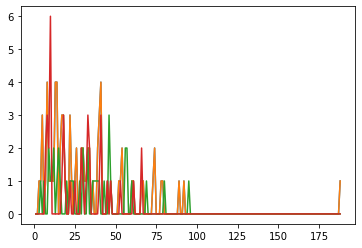

In [12]:
x_axis = np.arange(maximum_ob_time)+1 # the x axis
y_train_gt_axis = np.zeros(maximum_ob_time) # the ground truth train axis
y_val_gt_axis = np.zeros(maximum_ob_time) # the groud truth validation axis 
y_train_predict_axis = np.zeros(maximum_ob_time) # the predict train axis 
y_val_predict_axis = np.zeros(maximum_ob_time) # the predict validation axis 

for i in range(maximum_ob_time):
    y_train_gt_axis[i] = np.sum(survival_times[:NUM_TRAIN] == x_axis[i])
    y_val_gt_axis[i] = np.sum(survival_times[NUM_TRAIN:] == x_axis[i])
    y_train_predict_axis[i] = np.sum(predict_age[:NUM_TRAIN] == x_axis[i])
    y_val_predict_axis[i] = np.sum(predict_age[NUM_TRAIN:] == x_axis[i])
plt.plot(x_axis, y_train_gt_axis, x_axis, y_train_predict_axis) # the training set: ground truth vs predict situation
plt.plot(x_axis, y_val_gt_axis, x_axis, y_val_predict_axis) # the valiadtion set: ground truth vs predictsituation

# plt.plot(x_axis,y_train_predict_axis,y_val_predict_axis)

In [16]:
hatY_val += Kernel_Matrix_Val.dot(alpha*Y_train)
hatY_val /= t * weight_decay
print(Kernel_Matrix_Val[0])
print(hatY_val[0])
print(Y_val[0])

[0.42705152 0.68069577 0.65225658 0.56442101 0.56888928 0.57110134
 0.59848077 0.55570855 0.63312841 0.57339119 0.50409647 0.60527382
 0.39655072 0.56180514 0.54669228 0.63862865 0.52239152 0.61921799
 0.67301569 0.64066484 0.33168197 0.59625211 0.42639501 0.57616782
 0.64500639 0.37271217 0.5606506  0.49986206 0.57615098 0.54425982
 0.59875725 0.54251366 0.45731035 0.54510694 0.66887996 0.61025578
 0.59845823 0.5354902  0.60496916 0.56191317 0.56080232 0.56391771
 0.58691167 0.62331769 0.61059604 0.50115421 0.4718944  0.48904306
 0.45727469 0.42924922 0.55510899 0.33198993 0.47775406 0.61689293
 0.63009845 0.58205374 0.47529684 0.52657656 0.5147635  0.60785989
 0.52697639 0.45815025 0.52349705 0.51151622 0.41270323 0.40578708
 0.47178047 0.36698894 0.52555829 0.50716344 0.48760778 0.60255421
 0.57868283 0.50806466 0.53164134 0.61977721]
[ 0.2600703   0.2600703   0.10043623  0.08046428  0.02032181  0.02032181
  0.00720667  0.00332875  0.00796332 -0.00109689  0.00937416  0.00353186
 -0.